# Why hourly assortment performs bad?

In [2]:
import numpy as np
from scipy.optimize import minimize
from math import radians, cos, sin, asin, sqrt


In [3]:
import pandas as pd
import numpy as np
from main3_0623 import TemporalAnalyzer
import multiprocessing
import os
from datetime import datetime, timedelta
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing3 import Preprocessor
from estimation3 import Estimator, EstimationResult
import os

In [3]:
def time_period_in_minutes(start_time, end_time):
    """
    Calculate the time period in minutes between two time strings.
    
    Args:
        start_time (str): Start time in 'HH:MM' or 'HH:MM:SS' format
        end_time (str): End time in 'HH:MM' or 'HH:MM:SS' format
    
    Returns:
        float: Time period in minutes
    
    Raises:
        ValueError: If time strings are in an invalid format
    """
    try:
        start_dt = datetime.strptime(start_time, '%H:%M:%S')
        end_dt = datetime.strptime(end_time, '%H:%M:%S')
    except ValueError:
        try:
            start_dt = datetime.strptime(start_time, '%H:%M')
            end_dt = datetime.strptime(end_time, '%H:%M')
        except ValueError:
            raise ValueError("Invalid time format. Use 'HH:MM' or 'HH:MM:SS'.")
    
    delta = end_dt - start_dt
    if delta.total_seconds() < 0:
        delta += timedelta(days=1)
    return delta.total_seconds() / 60


In [4]:
data_path = '/home/go3/wch_code/jx/real_data/data/cleaned_data2.csv'
df = pd.read_csv(data_path)

In [5]:
df

,Unnamed: 0.1,Unnamed: 0,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,...,grab_lng,grab_lat,dispatch_time,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time,estimate_duration
0,1,1,20221017,1,1,1,1,1,1,2022-10-17 00:31:04,...,174530062,45906005,2022-10-17 00:12:14,2022-10-17 00:12:17,2022-10-17 00:22:24,2022-10-17 00:29:58,2022-10-17 00:14:05,2022-10-17 00:00:06,2022-10-16 23:59:55,0 days 00:31:09
1,2,2,20221017,2,2,2,2,1,0,2022-10-17 00:58:24,...,174548244,45870923,2022-10-17 00:24:44,2022-10-17 00:25:01,2022-10-17 00:39:06,2022-10-17 00:56:24,2022-10-17 00:33:27,2022-10-17 00:18:27,2022-10-17 00:18:17,0 days 00:40:07
2,3,3,20221017,3,3,3,0,1,0,2022-10-17 00:57:12,...,174560199,45867948,2022-10-17 00:23:14,2022-10-17 00:23:17,2022-10-17 00:30:30,2022-10-17 01:03:42,2022-10-17 00:27:14,2022-10-17 00:22:49,2022-10-17 00:17:08,0 days 00:40:04
3,4,4,20221017,4,4,4,0,1,0,2022-10-17 00:48:14,...,174554896,45865167,2022-10-17 00:23:14,2022-10-17 00:23:33,2022-10-17 00:28:30,2022-10-17 00:37:42,2022-10-17 00:28:14,2022-10-17 00:22:53,2022-10-17 00:18:12,0 days 00:30:02
4,5,5,20221017,5,5,5,3,1,0,2022-10-17 01:15:00,...,174526338,45912309,2022-10-17 00:45:27,2022-10-17 00:45:41,2022-10-17 01:07:41,2022-10-17 01:14:56,2022-10-17 00:53:45,2022-10-17 00:40:03,2022-10-17 00:39:59,0 days 00:35:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568541,654337,654337,20221024,568542,654337,1852,9,1,0,2022-10-24 23:13:31,...,174648556,45879505,2022-10-24 22:45:57,2022-10-24 22:46:02,2022-10-24 22:53:51,2022-10-24 23:05:14,2022-10-24 23:03:32,2022-10-24 22:43:32,2022-10-24 22:39:50,0 days 00:33:41
568542,654339,654339,20221024,568543,654339,1957,0,1,0,2022-10-24 23:27:19,...,174576809,45873238,2022-10-24 22:57:18,2022-10-24 22:57:43,2022-10-24 23:11:27,2022-10-24 23:18:09,2022-10-24 23:09:12,2022-10-24 22:57:16,2022-10-24 22:55:13,0 days 00:32:06
568543,654340,654340,20221024,568544,654340,2323,9,1,0,2022-10-25 00:03:12,...,174624149,45872077,2022-10-24 23:27:27,2022-10-24 23:27:41,2022-10-24 23:43:47,2022-10-24 23:59:32,2022-10-24 23:32:14,2022-10-24 23:27:07,2022-10-24 23:22:03,0 days 00:41:09
568544,654341,654341,20221024,162081,654341,211,12,1,0,2022-10-25 00:20:12,...,174537979,45895683,2022-10-24 23:53:47,2022-10-24 23:54:02,2022-10-25 00:05:38,2022-10-25 00:16:37,2022-10-24 23:59:13,2022-10-24 23:50:13,2022-10-24 23:49:59,0 days 00:30:13


In [4]:
data_path = '/home/go3/wch_code/jx/real_data/data/cleaned_data2.csv'
df = pd.read_csv(data_path)
training_dates = ['2022-10-17', '2022-10-18', '2022-10-19']
testing_dates = ['2022-10-20', '2022-10-21']

# Define distance and time window configurations
dist_per_grid_list = [
    # 0.3, 0.4,
    # 0.5,
    # 0.6
    # 0.7, 0.8, 0.9,
    # 1.0
    # , 
    1.5, 
    # 2.0, 2.5, 
    # 3.0, 
    # 4.0, 5.0
    ]
time_windows_configs = [
    ('full_day', [
        # ('08:00', '10:00'),
        # ('08:00:00', '09:59:59'),
        # ('10:00:00', '11:59:59'), 
        ('12:00:00', '13:59:59'),
        # ('08:00:00', '08:59:59'), 
        # ('09:00:00', '09:59:59'), 
        # ('10:00:00', '10:59:59'), 
        # ('11:00:00', '11:59:59'), 
        # ('12:00:00', '12:59:59'),
        # ('13:00:00', '13:59:59'),
        # ('14:00:00', '14:59:59'), 
        # ('15:00:00', '15:59:59'), 
        # ('16:00:00', '16:59:59'),
        # ('17:00:00', '17:59:59'), 
        # ('18:00:00', '18:59:59'),
        # ('19:00:00', '19:59:59'),
        # ('20:00:00', '20:59:59'),
        # ('21:00:00', '21:59:59'), 
        # ('22:00:00', '22:59:59'),
        # ('23:00:00', '23:59:59')
    ])
]

time_windows = time_windows_configs[0][1]  # Use 'full_day' time windows
timeperiod = time_period_in_minutes(time_windows[0][0], time_windows[0][1])


In [74]:
timeperiod

119.98333333333333

In [72]:
timeperiod

120.0

In [5]:
combinations = list(product(dist_per_grid_list, time_windows))
combinations

[(1.5, ('12:00:00', '13:59:59'))]

In [6]:
args_list = [(dpg, tw, 
              df, 
              timeperiod, training_dates, testing_dates) 
                    for dpg, tw in combinations]
# args_list[0]

In [114]:
dpg = dist_per_grid_list[0]
tw = time_windows[0]


In [7]:
"""Run analysis for a single combination of dist_per_grid and time window."""
dpg, tw, df, timeperiod, training_dates, testing_dates = args_list[0]

# result = TemporalAnalyzer.run_analysis(
df=df
time_intervals=[tw]
dist_per_grid=dpg
timeperiod=timeperiod
training_dates=training_dates
testing_dates=testing_dates
max_iter=100
tol=5e-4
grid_dependent=True
penalty=0
# )
training_dates = [pd.to_datetime(date).date() for date in training_dates]
testing_dates = [pd.to_datetime(date).date() for date in testing_dates]
all_dates = training_dates + testing_dates
# base_df = Preprocessor.preprocess(df, all_dates)
start_date='2022-10-17 00:00:00'
end_date='2022-10-25 00:00:00'
df = df.loc[(df['platform_order_time'] >= start_date) & (df['platform_order_time'] <= end_date)].copy()
df['platform_order_time'] = pd.to_datetime(df['platform_order_time'])
df['time'] = df['platform_order_time'].dt.time
df['date'] = df['platform_order_time'].dt.date
dates = [pd.to_datetime(date).date() for date in all_dates]
base_df = df.loc[df['date'].isin(dates)]

In [128]:
time_intervals

[('10:00:00', '11:59:59')]

Compute assortment for training data

In [8]:
results = []
for win_start, win_end in time_intervals:
    win_start = win_start
    win_end = win_end
print('now compute fixed assortments, for dist_per_grid:', dist_per_grid, 'time_interval:', win_start, '-', win_end)
# calculate number of cells
base_df_tw, num_total_cells, num_cells_lon, _, _, _, _ = Preprocessor.cut_df(base_df, dist_per_grid, timeperiod)
# get assortment matrix
# fixed_assortments = Preprocessor.compute_fixed_assortments(base_df_tw, dist_per_grid, num_total_cells)

print(f"Processing time window: {win_start} to {win_end}")
start_time = pd.to_datetime(win_start).time()
end_time = pd.to_datetime(win_end).time()
win_df_train = base_df_tw[(base_df_tw['date'].isin(training_dates)) & 
                        (base_df_tw['time'] >= start_time) & 
                        (base_df_tw['time'] <= end_time)].copy()
win_df_train['time_window'] = f"{win_start}-{win_end}"

train_fixed_assortments = Preprocessor.compute_fixed_assortments(win_df_train, dist_per_grid, num_total_cells)
        
print(f"Completed analysis for dist_per_grid={dpg}, time_window={tw}")

now compute fixed assortments, for dist_per_grid: 1.5 time_interval: 12:00:00 - 13:59:59
Processing time window: 12:00:00 to 13:59:59
Completed analysis for dist_per_grid=1.5, time_window=('12:00:00', '13:59:59')


In [37]:
win_df_train['cust_index'].unique()

array([ 40,  70,  62,  84,  49,  92,  52,  63,  69,  64,  83,  75, 105,
        17,  82,  48,  47,  71,  50,  74,  27,  73,  80,  51,  60,  61,
        59,  65,  91,  81,  37,  15,  39,  94,  18,  95,  86,  38, 104,
        41,  16, 103,  72,  29,  36,  93, 102,  56,  87,  28,  89,  57,
        85,  54, 106,  31,  14,  58, 115, 114,  79,  42,  46,  25,  19,
         4,  26,  13,  53,  67,   6,  97,  90,  35,   7,  68,  34,   5,
        76,  24, 108,  30,  78, 113,  98, 101,   8,  44, 116])

In [38]:
win_df_train['sell_index'].unique()

array([ 51,  71,  61,  72,  50,  73,  81,  62,  38,  83,  92,  60,  48,
        59,  52,  63,  84,  49,  82,  65,  64,  27,  41,  75,  39,  70,
        80,  40, 105,  93,  47,  37,  14,  91,  45,  95, 102,  16,  94,
        29,  26,  58,  69, 104,  28,  36,  74,  35,  15,  17, 106,  19])

In [53]:
train_fixed_assortments[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

# Hourly assortment

Estimate Parameters

In [9]:
# omega, beta, lambda_hat, dist, p_m = Estimator.estimate_parameters(num_total_cells, num_cells_lon,
#                     win_df_train, dist_per_grid, timeperiod, max_iter=max_iter, tol=tol, fixed_assortments = train_fixed_assortments, penalty=penalty)
# num_total_cells
# num_cells_lon
window_df = win_df_train
dist_per_grid=dpg
timeperiod= timeperiod
max_iter=200
tol=1e-5
fixed_assortments = train_fixed_assortments
penalty=0               

In [10]:
df_processed, dist = Estimator.pre_process(window_df, num_cells_lon, dist_per_grid, num_total_cells)

In [ ]:
# omega, beta = Estimator.EM(dist_per_grid, df_processed, dist, num_total_cells, fixed_assortments, max_iter=max_iter, 
#                                    tol=tol, penalty=penalty)


In [11]:
def objective_beta(beta, cust_idx, sell_idx, omega, p_m, factor, dist, num_total_cells, fixed_assortments, penalty=0):
    try:
        p = Estimator.compute_p(beta, dist, num_total_cells, fixed_assortments)
        log_p_purchase = np.log(p[cust_idx, sell_idx] + 1e-15)
        log_p_no_purchase = np.log(p[:, -1] + 1e-15)
        p_no_purchase = p[:, -1] + 1e-15
        reg = penalty * np.sum(beta**2)
        return -(np.sum(log_p_purchase) + factor * np.sum(p_no_purchase * omega * log_p_no_purchase) - reg)
    except:
        return np.inf

In [12]:
df = df_processed.copy()
N = len(df)
omega = np.ones(num_total_cells) / num_total_cells
beta = np.zeros(1 + num_total_cells + num_total_cells)
beta[0] = 10
beta[1:1 + num_total_cells] = 0
beta[1 + num_total_cells:] = 0

for iteration in range(max_iter):
    p_m = Estimator.compute_p(beta, dist, num_total_cells, fixed_assortments)
    sum_p_no_purchase = (omega * p_m[:, -1]).sum()
    if (1 - sum_p_no_purchase) < 1e-6:
        break
    factor = N / (1 - sum_p_no_purchase)
    c = np.array([(df['cust_index'] == i ).sum() + factor * omega[i] * p_m[i, -1] 
                    for i in range(num_total_cells)])
    omega_new = c / (c.sum())
    res = minimize(
        objective_beta, beta,
        args=(df['cust_index'].values, df['sell_index'].values, omega, p_m, factor, dist, 
                num_total_cells, fixed_assortments, penalty),
        method='L-BFGS-B',
        bounds=[(0, None)] + [(None, None)] * num_total_cells + [(None, None)] * num_total_cells
    )
    beta_new = res.x
    rate_change_beta = np.max(np.abs(beta_new - beta) / (1000 * (beta + 1e-10)))
    print(f'dist_per_grid: {dist_per_grid}| iteration: {iteration} | diff_omega: {np.max(np.abs(omega_new - omega))} | diff_beta: {rate_change_beta}')
    if (np.max(np.abs(omega_new - omega)) < tol) and (rate_change_beta < tol):
        print(f"Converged at iteration {iteration}")
        break
    omega, beta = omega_new, beta_new
    print(f"Iter {iteration}: Loss {res.fun:.2f}, Alpha {beta[0]:.3f}")


dist_per_grid: 1.5| iteration: 0 | diff_omega: 0.011301814514326994 | diff_beta: 95402487.9996538
Iter 0: Loss 57383.07, Alpha 0.812
dist_per_grid: 1.5| iteration: 1 | diff_omega: 0.02509162455020098 | diff_beta: 0.0035177188737850374
Iter 1: Loss 56865.72, Alpha 0.801
dist_per_grid: 1.5| iteration: 2 | diff_omega: 9.329662379662165e-05 | diff_beta: 0.0036169775756818316
Iter 2: Loss 56832.74, Alpha 0.800
dist_per_grid: 1.5| iteration: 3 | diff_omega: 4.5696850077447254e-05 | diff_beta: 0.0035073139197576227
Iter 3: Loss 56826.84, Alpha 0.800
dist_per_grid: 1.5| iteration: 4 | diff_omega: 5.234353577519401e-05 | diff_beta: 0.001536177790924986
Iter 4: Loss 56824.49, Alpha 0.800
dist_per_grid: 1.5| iteration: 5 | diff_omega: 1.795948298033076e-05 | diff_beta: 0.00020981396615022695
Iter 5: Loss 56822.77, Alpha 0.801
dist_per_grid: 1.5| iteration: 6 | diff_omega: 8.25658431652214e-06 | diff_beta: 0.00020959307831806338
Iter 6: Loss 56822.20, Alpha 0.800
dist_per_grid: 1.5| iteration: 7 |

In [13]:
p_m = Estimator.compute_p(beta, dist, num_total_cells, fixed_assortments)
T_train = df_processed['time_index'].nunique()
sum_over_l_b = (omega[:, None] * p_m[:, :-1]).sum()
d_eval = df_processed['date'].nunique()
lambda_hat = len(df_processed) / (d_eval * T_train * sum_over_l_b) if T_train * sum_over_l_b != 0 else 0


In [14]:
lambda_hat

6589.331238652052

In [61]:
p_m[:, 22]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [162]:
(p_m[:,c].sum() for c in range(num_total_cells))

<>:1: SyntaxWarning: 'generator' object is not subscriptable; perhaps you missed a comma?
<>:1: SyntaxWarning: 'generator' object is not subscriptable; perhaps you missed a comma?
/tmp/ipykernel_1486959/2148539055.py:1: SyntaxWarning: 'generator' object is not subscriptable; perhaps you missed a comma?
  (p_m[:,c].sum() for c in range(num_total_cells))[0]


TypeError: 'generator' object is not subscriptable

In [62]:
p_m[:,22]# sum of probability who choose cell 22

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [63]:
p_m[0]  # sum of probability who choose no purchase

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1.])

In [172]:
omega.shape

(272,)

In [174]:
len([(p_m[:,c]).sum() for c in range(num_total_cells)])

272

In [175]:
[(p_m[:,c]).sum() for c in range(num_total_cells)]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.927956733061163e-08,
 0.0,
 2.631011121234967e-07,
 4.18930119370927e-08,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.621562679216174e-07,
 3.8612427621400205e-07,
 3.248358287386744e-07,
 7.222339655745682e-08,
 5.4801754563511245e-08,
 5.390471056459513e-08,
 0.0,
 1.9620464795396527e-08,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.8437338788445172e-07,
 4.704740159021869e-07,
 5.563460976799247e-07,
 6.282802344143776e-08,
 4.887736419783454e-08,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.589896037160468e-06,
 2.013945606782034e-06,
 9.094937592621696e-07,
 3.298978676172819e-05,
 0.0,
 2.530612732715542e-08,
 4.086733977803055e-08,
 0.0,
 0.0,
 0.0,
 0.0,
 5.338161646157394e-08,
 4.49196643236953e-08,
 1.9434885835280908e-07,
 3.868960693315665e-06,
 4.704451614215787e-06,
 3.9560

In [166]:
N_hat = np.array([lambda_hat * omega * (p_m[:,c]).sum() for c in range(num_total_cells)])


In [91]:
# count how many orders made in cust_index = 15
cust_index = 0
orders_count = win_df_train[win_df_train['cust_index'] == cust_index].shape[0]
print(f"Number of orders made by customer {cust_index}: {orders_count}")

Number of orders made by customer 6: 722


In [92]:
win_df_train[win_df_train['cust_index'] == cust_index]['sell_index'].unique()

array([ 6, 10,  5,  7,  9, 11,  2,  1])

In [93]:
train_fixed_assortments[1]

array([0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [96]:
lambda_hat

715530712.7775792

In [151]:
p_m[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [15]:
def calculate_wmape(extra_assortment, p_m, omega, beta, lambda_hat, dist, eval_df, dist_per_grid, timeperiod):
    eval_df, num_total_cells, _, _, _, _, _ = Preprocessor.cut_df(eval_df, dist_per_grid, timeperiod)
    T_eval = eval_df['time_index'].nunique()
    
    # if extra_assortment == True:
    # special note:
    p_m = Estimator.compute_p(beta, dist, num_total_cells, extra_assortment)

    # Calculate actual o_ij
    o_ij_actual = np.zeros((num_total_cells, num_total_cells))
    for _, row in eval_df.iterrows(): # 
        i = row['cust_index']  # Adjust to 0-based index
        j = row['sell_index']  # Adjust to 0-based index
        # calculate choose probability for each i, j
        o_ij_actual[i, j] += 1
    # pdb.set_trace()
    # o_ij_actual = o_ij_actual / o_ij_actual.sum(axis=1, keepdims=True) if o_ij_actual.sum(axis=1, keepdims=True) > 0 else 0

    # Calculate predicted o_ij
    o_ij_hat = np.zeros((num_total_cells, num_total_cells))
    for i in range(num_total_cells):
        for j in range(num_total_cells):
            # calculate choose probability for each i, j
            o_ij_hat[i, j] = lambda_hat * T_eval * omega[i] * p_m[i, j]
        # normalize each row to sum to 1
        o_ij_actual[i, :] = o_ij_actual[i, :] / o_ij_actual[i, :].sum() if o_ij_actual[i, :].sum() > 0 else 0
        o_ij_hat[i, :] = o_ij_hat[i, :] / o_ij_hat[i, :].sum() if o_ij_hat[i, :].sum() > 0 else 0

    # pdb.set_trace()
    # o_ij_hat = o_ij_hat / o_ij_hat.sum(axis=1, keepdims=True) if o_ij_hat.sum(axis=1, keepdims=True) > 0 else 0

    # Calculate relative error for each i, j where o_ij > 0
    # relative_errors = []
    # for i in range(num_total_cells):
    #     for j in range(num_total_cells):
    #         # if o_ij_actual[i, j] > 0:
    #         error = abs(o_ij_hat[i, j] - o_ij_actual[i, j]) / (o_ij_actual[i, j] + 1e-6) * 100
    #         relative_errors.append(error)
    
    # flatten the arrays to 1D
    o_ij_actual = o_ij_actual.flatten()
    o_ij_hat = o_ij_hat.flatten()

    # Calculate relative errors, only division by o_ij_actual where o_ij_actual > 0
    # relative_errors = np.where(o_ij_actual > 0, (np.abs(o_ij_actual - o_ij_hat) / o_ij_actual) * 100, 0)
    # turn off the error report for division by zero
    # relative_errors = np.where(o_ij_actual > 0, (np.abs(o_ij_actual - o_ij_hat) / o_ij_actual) * 100, 0)
    
    relative_errors = np.abs(o_ij_actual - o_ij_hat)

    # remove inf values from relative_errors away
    relative_errors = relative_errors[~np.isinf(relative_errors) & ~np.isnan(relative_errors)]  # remove inf values
    # print(f'Relative errors: {relative_errors}')
    # relative_errors = (np.abs(o_ij_actual - o_ij_hat) / o_ij_actual) * 100  if o_ij_actual > 0 else 0


    # Calculate WMAPE as before
    N_hat = np.array([lambda_hat * T_eval * (omega * p_m[:, c]).sum() for c in range(num_total_cells)])
    N_actual = np.zeros(num_total_cells)
    for i in range(num_total_cells):
        N_actual[i] = len(eval_df[(eval_df['sell_index'] == i)])
    wmape = (np.abs(N_actual - N_hat).sum() / N_actual.sum()) * 100 if N_actual.sum() > 0 else 0 # shape: 
    # print(f'N_hat: {N_hat} | N_actual: {N_actual}\nT_eval: {T_eval} | wmape: {wmape}')
    
    return wmape, relative_errors

In [18]:
T_eval = win_df_test['time_index'].nunique()
N_hat = np.array([lambda_hat * T_eval * (omega * p_m[:, c]).sum() for c in range(num_total_cells)])

In [19]:
N_actual = np.zeros(num_total_cells)
for i in range(num_total_cells):
    N_actual[i] = len(win_df_test[(win_df_test['sell_index'] == i)])

In [20]:
(np.abs(N_actual - N_hat).sum() / N_actual.sum()) * 100 if N_actual.sum() > 0 else 0

8.707020328526713

In [26]:
lambda_hat

6589.331238652052

In [22]:
sum(N_actual)

9281.0

In [31]:
# for non-zero N_actual
non_zero_indices = N_actual > 0
N_hat_non_zero = N_hat[non_zero_indices]
N_actual_non_zero = N_actual[non_zero_indices]
error = np.abs(N_actual_non_zero - N_hat_non_zero) / N_actual_non_zero * 100

In [35]:
np.mean(error)

23.725304465405088

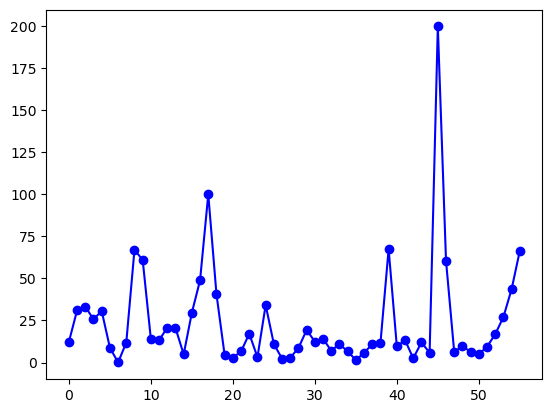

In [33]:
plt.plot(error, marker='o', linestyle='-', color='b')

In [29]:
(sum(N_actual) -sum(N_hat)) / sum(N_actual)

0.06389397694214005

In [21]:
sum(N_hat)

8687.999999999998

In [17]:
win_df_test = base_df_tw[(base_df_tw['date'].isin(testing_dates)) & 
                    (base_df_tw['time'] >= start_time) & 
                    (base_df_tw['time'] <= end_time)].copy()
win_df_test['time_window'] = f"{win_start}-{win_end}"


# calculate the ratio of overlap 

out_sample_wmapes = {}
out_sample_relative_errors = []
out_sample_assort_ratio = {}
for test_date in testing_dates:
    win_df_test = base_df_tw[(base_df_tw['date'] == test_date) & 
                            (base_df_tw['time'] >= start_time) & 
                            (base_df_tw['time'] <= end_time)].copy()
    test_fixed_assortments = Preprocessor.compute_fixed_assortments(win_df_test, dist_per_grid, num_total_cells)
    if len(win_df_test) > 0:
        out_sample_wmape, relative_errors = calculate_wmape(
            test_fixed_assortments,
            p_m, omega, beta, lambda_hat, dist,
            win_df_test, dist_per_grid, timeperiod)
        
        out_sample_wmapes[test_date] = out_sample_wmape
        out_sample_relative_errors.extend(relative_errors)


In [69]:
np.sum(out_sample_relative_errors)

67.77736887982026

In [70]:
out_sample_wmapes

{datetime.date(2022, 10, 20): 6.939894672126402,
 datetime.date(2022, 10, 21): 8.166429988658843}

# 5km assort

In [8]:
def compute_fixed_assortments(df, dist, num_total_cells, dist_threshold=5.0):

    # fixed_assortments = np.zeros((num_total_cells, num_total_cells))
    # for i in range(num_total_cells):
    #     grid_df = df[df['cust_index'] == i]
    #     chosen_sellers = grid_df['sell_index'].unique()
    #     fixed_assortments[i, chosen_sellers] = 1
    mask = (dist <= dist_threshold)
    # fixed_assortments = fixed_assortments * mask # shape (num_total_cells, num_total_cells)
    fixed_assortments = mask
    return fixed_assortments

In [9]:
results = []
for win_start, win_end in time_intervals:
    win_start = win_start
    win_end = win_end
print('now compute fixed assortments, for dist_per_grid:', dist_per_grid, 'time_interval:', win_start, '-', win_end)
# calculate number of cells
base_df_tw, num_total_cells, num_cells_lon, _, _, _, _ = Preprocessor.cut_df(base_df, dist_per_grid, timeperiod)
# get assortment matrix
# fixed_assortments = Preprocessor.compute_fixed_assortments(base_df_tw, dist_per_grid, num_total_cells)

print(f"Processing time window: {win_start} to {win_end}")
start_time = pd.to_datetime(win_start).time()
end_time = pd.to_datetime(win_end).time()
win_df_train = base_df_tw[(base_df_tw['date'].isin(training_dates)) & 
                        (base_df_tw['time'] >= start_time) & 
                        (base_df_tw['time'] <= end_time)].copy()
win_df_train['time_window'] = f"{win_start}-{win_end}"

train_fixed_assortments = compute_fixed_assortments(win_df_train, dist_per_grid, num_total_cells)
        
print(f"Completed analysis for dist_per_grid={dpg}, time_window={tw}")

now compute fixed assortments, for dist_per_grid: 1.0 time_interval: 10:00:00 - 11:59:59
Processing time window: 10:00:00 to 11:59:59
Completed analysis for dist_per_grid=1.0, time_window=('10:00:00', '11:59:59')


In [10]:
train_fixed_assortments = compute_fixed_assortments(win_df_train, dist_per_grid, num_total_cells)
      

In [11]:
# omega, beta, lambda_hat, dist, p_m = Estimator.estimate_parameters(num_total_cells, num_cells_lon,
#                     win_df_train, dist_per_grid, timeperiod, max_iter=max_iter, tol=tol, fixed_assortments = train_fixed_assortments, penalty=penalty)
# num_total_cells
# num_cells_lon
window_df = win_df_train
dist_per_grid=dpg
timeperiod= timeperiod
max_iter=200
tol=1e-6
fixed_assortments = train_fixed_assortments
penalty=0               

In [12]:
df_processed, dist = Estimator.pre_process(window_df, num_cells_lon, dist_per_grid, num_total_cells)

In [13]:
df = df_processed.copy()
N = len(df)
omega = np.ones(num_total_cells) / num_total_cells
beta = np.zeros(1 + num_total_cells + num_total_cells)
beta[0] = 10
beta[1:1 + num_total_cells] = 0
beta[1 + num_total_cells:] = 0

for iteration in range(max_iter):
    p_m = Estimator.compute_p(beta, dist, num_total_cells, fixed_assortments)
    sum_p_no_purchase = (omega * p_m[:, -1]).sum()
    if (1 - sum_p_no_purchase) < 1e-6:
        break
    factor = N / (1 - sum_p_no_purchase)
    c = np.array([(df['cust_index'] == i ).sum() + factor * omega[i] * p_m[i, -1] 
                    for i in range(num_total_cells)])
    omega_new = c / (c.sum())
    res = minimize(
        Estimator.objective_beta, beta,
        args=(df['cust_index'].values, df['sell_index'].values, omega, p_m, factor, dist, 
                num_total_cells, fixed_assortments, penalty),
        method='L-BFGS-B',
        bounds=[(0, None)] + [(None, None)] * num_total_cells + [(None, None)] * num_total_cells
    )
    beta_new = res.x
    rate_change_beta = np.max(np.abs(beta_new - beta) / (1000 * (beta + 1e-10)))
    print(f'dist_per_grid: {dist_per_grid}| iteration: {iteration} | diff_omega: {np.max(np.abs(omega_new - omega))} | diff_beta: {rate_change_beta}')
    if (np.max(np.abs(omega_new - omega)) < tol) and (rate_change_beta < tol):
        print(f"Converged at iteration {iteration}")
        break
    omega, beta = omega_new, beta_new
    print(f"Iter {iteration}: Loss {res.fun:.2f}, Alpha {beta[0]:.3f}")


dist_per_grid: 1.0| iteration: 0 | diff_omega: 0.017213830366508434 | diff_beta: 53474321.15575557
Iter 0: Loss 173705.37, Alpha 1.037
dist_per_grid: 1.0| iteration: 1 | diff_omega: 0.006042186700510845 | diff_beta: 0.05079010943843646
Iter 1: Loss 200914.71, Alpha 0.985
dist_per_grid: 1.0| iteration: 2 | diff_omega: 0.0038602875641194252 | diff_beta: 0.0027095256049492313
Iter 2: Loss 214221.37, Alpha 1.030
dist_per_grid: 1.0| iteration: 3 | diff_omega: 0.0031342637303621995 | diff_beta: 0.0035998146800189567
Iter 3: Loss 226042.55, Alpha 1.049
dist_per_grid: 1.0| iteration: 4 | diff_omega: 0.002079599614872224 | diff_beta: 0.002527366331341369
Iter 4: Loss 234522.05, Alpha 1.022
dist_per_grid: 1.0| iteration: 5 | diff_omega: 0.001551717697753599 | diff_beta: 0.001502034795492199
Iter 5: Loss 243973.57, Alpha 1.041
dist_per_grid: 1.0| iteration: 6 | diff_omega: 0.00107441865434256 | diff_beta: 0.0028588198901547926
Iter 6: Loss 251903.96, Alpha 1.037
dist_per_grid: 1.0| iteration: 7 |

In [14]:
p_m = Estimator.compute_p(beta, dist, num_total_cells, fixed_assortments)
T_train = df_processed['time_index'].nunique()
sum_over_l_b = (omega[:, None] * p_m[:, :-1]).sum()
d_eval = df_processed['date'].nunique()
lambda_hat = len(df_processed) / (d_eval * T_train * sum_over_l_b) if T_train * sum_over_l_b != 0 else 0


train with 5km assortment

In [17]:
win_df_test = base_df_tw[(base_df_tw['date'].isin(testing_dates)) & 
                    (base_df_tw['time'] >= start_time) & 
                    (base_df_tw['time'] <= end_time)].copy()
win_df_test['time_window'] = f"{win_start}-{win_end}"


# calculate the ratio of overlap 

out_sample_wmapes = {}
out_sample_relative_errors = []
out_sample_assort_ratio = {}
for test_date in testing_dates:
    win_df_test = base_df_tw[(base_df_tw['date'] == test_date) & 
                            (base_df_tw['time'] >= start_time) & 
                            (base_df_tw['time'] <= end_time)].copy()
    # test_fixed_assortments = compute_fixed_assortments(win_df_test, dist_per_grid, num_total_cells)
    if len(win_df_test) > 0:
        out_sample_wmape, relative_errors = calculate_wmape(
            train_fixed_assortments,
            p_m, omega, beta, lambda_hat, dist,
            win_df_test, dist_per_grid, timeperiod)
        
        out_sample_wmapes[test_date] = out_sample_wmape
        out_sample_relative_errors.extend(relative_errors)


In [18]:
out_sample_wmapes

{datetime.date(2022, 10, 20): 90.91315254558697,
 datetime.date(2022, 10, 21): 92.44809029290042}

test with observed assortment

In [39]:
win_df_test = base_df_tw[(base_df_tw['date'].isin(testing_dates)) & 
                    (base_df_tw['time'] >= start_time) & 
                    (base_df_tw['time'] <= end_time)].copy()
win_df_test['time_window'] = f"{win_start}-{win_end}"


# calculate the ratio of overlap 

out_sample_wmapes = {}
out_sample_relative_errors = []
out_sample_assort_ratio = {}
for test_date in testing_dates:
    win_df_test = base_df_tw[(base_df_tw['date'] == test_date) & 
                            (base_df_tw['time'] >= start_time) & 
                            (base_df_tw['time'] <= end_time)].copy()
    test_fixed_assortments = compute_fixed_assortments(win_df_test, dist_per_grid, num_total_cells)
    if len(win_df_test) > 0:
        out_sample_wmape, relative_errors = calculate_wmape(
            test_fixed_assortments,
            p_m, omega, beta, lambda_hat, dist,
            win_df_test, dist_per_grid, timeperiod)
        
        out_sample_wmapes[test_date] = out_sample_wmape
        out_sample_relative_errors.extend(relative_errors)


In [40]:
out_sample_wmapes

{datetime.date(2022, 10, 20): 12.838474528772153,
 datetime.date(2022, 10, 21): 13.01573252565281}

test without observed assortment

In [36]:
def calculate_wmape(extra_assortment, p_m, omega, beta, lambda_hat, dist, eval_df, dist_per_grid, timeperiod):
    eval_df, num_total_cells, _, _, _, _, _ = Preprocessor.cut_df(eval_df, dist_per_grid, timeperiod)
    T_eval = eval_df['time_index'].nunique()
    
    # if extra_assortment == True:
    # special note:
    p_m = Estimator.compute_p(beta, dist, num_total_cells, extra_assortment)

    # Calculate actual o_ij
    o_ij_actual = np.zeros((num_total_cells, num_total_cells))
    for _, row in eval_df.iterrows(): # 
        i = row['cust_index'] - 1  # Adjust to 0-based index
        j = row['sell_index'] - 1  # Adjust to 0-based index
        # calculate choose probability for each i, j
        o_ij_actual[i, j] += 1
    # pdb.set_trace()
    # o_ij_actual = o_ij_actual / o_ij_actual.sum(axis=1, keepdims=True) if o_ij_actual.sum(axis=1, keepdims=True) > 0 else 0

    # Calculate predicted o_ij
    o_ij_hat = np.zeros((num_total_cells, num_total_cells))
    for i in range(num_total_cells):
        for j in range(num_total_cells):
            # calculate choose probability for each i, j
            o_ij_hat[i, j] = lambda_hat * T_eval * omega[i] * p_m[i, j]
        # normalize each row to sum to 1
        o_ij_actual[i, :] = o_ij_actual[i, :] / o_ij_actual[i, :].sum() if o_ij_actual[i, :].sum() > 0 else 0
        o_ij_hat[i, :] = o_ij_hat[i, :] / o_ij_hat[i, :].sum() if o_ij_hat[i, :].sum() > 0 else 0

    # pdb.set_trace()
    # o_ij_hat = o_ij_hat / o_ij_hat.sum(axis=1, keepdims=True) if o_ij_hat.sum(axis=1, keepdims=True) > 0 else 0

    # Calculate relative error for each i, j where o_ij > 0
    # relative_errors = []
    # for i in range(num_total_cells):
    #     for j in range(num_total_cells):
    #         # if o_ij_actual[i, j] > 0:
    #         error = abs(o_ij_hat[i, j] - o_ij_actual[i, j]) / (o_ij_actual[i, j] + 1e-6) * 100
    #         relative_errors.append(error)
    
    # flatten the arrays to 1D
    o_ij_actual = o_ij_actual.flatten()
    o_ij_hat = o_ij_hat.flatten()

    # Calculate relative errors, only division by o_ij_actual where o_ij_actual > 0
    # relative_errors = np.where(o_ij_actual > 0, (np.abs(o_ij_actual - o_ij_hat) / o_ij_actual) * 100, 0)
    # turn off the error report for division by zero
    # relative_errors = np.where(o_ij_actual > 0, (np.abs(o_ij_actual - o_ij_hat) / o_ij_actual) * 100, 0)
    
    relative_errors = np.abs(o_ij_actual - o_ij_hat)

    # remove inf values from relative_errors away
    relative_errors = relative_errors[~np.isinf(relative_errors) & ~np.isnan(relative_errors)]  # remove inf values
    # print(f'Relative errors: {relative_errors}')
    # relative_errors = (np.abs(o_ij_actual - o_ij_hat) / o_ij_actual) * 100  if o_ij_actual > 0 else 0


    # Calculate WMAPE as before
    N_hat = np.array([lambda_hat * T_eval * (omega * p_m[:, c]).sum() for c in range(num_total_cells)])
    N_actual = np.zeros(num_total_cells)
    for i in range(num_total_cells):
        N_actual[i] = len(eval_df[(eval_df['sell_index'] == i+1)])
    wmape = (np.abs(N_actual - N_hat).sum() / N_actual.sum()) * 100 if N_actual.sum() > 0 else 0 # shape: 
    # print(f'N_hat: {N_hat} | N_actual: {N_actual}\nT_eval: {T_eval} | wmape: {wmape}')
    
    return wmape, relative_errors

In [37]:
win_df_test = base_df_tw[(base_df_tw['date'].isin(testing_dates)) & 
                    (base_df_tw['time'] >= start_time) & 
                    (base_df_tw['time'] <= end_time)].copy()
win_df_test['time_window'] = f"{win_start}-{win_end}"


# calculate the ratio of overlap 

out_sample_wmapes = {}
out_sample_relative_errors = []
out_sample_assort_ratio = {}
for test_date in testing_dates:
    win_df_test = base_df_tw[(base_df_tw['date'] == test_date) & 
                            (base_df_tw['time'] >= start_time) & 
                            (base_df_tw['time'] <= end_time)].copy()
    # test_fixed_assortments = compute_fixed_assortments(win_df_test, dist_per_grid, num_total_cells)
    if len(win_df_test) > 0:
        out_sample_wmape, relative_errors = calculate_wmape(
            train_fixed_assortments,
            p_m, omega, beta, lambda_hat, dist,
            win_df_test, dist_per_grid, timeperiod)
        
        out_sample_wmapes[test_date] = out_sample_wmape
        out_sample_relative_errors.extend(relative_errors)


In [38]:
out_sample_wmapes

{datetime.date(2022, 10, 20): 12.838474528772153,
 datetime.date(2022, 10, 21): 13.01573252565281}

In [ ]:
out_sample_wmapes

When grids smaller, hit ratio 